# Outline

* Importing all required packages and data
* Introduction
* Example #1 - Iris Dataset
* Example #1 - Results Interpretation
* Example #2 - Cars Dataset
* Example #2 - Results Interpretation
* Warning
* Conclusion

# Importing all required packages and data





In [1]:
from statsmodels.stats.weightstats import ttest_ind
import statsmodels.formula.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

iris_dat = pd.read_csv('/kaggle/input/iris/Iris.csv')
car_dat = pd.read_csv('/kaggle/input/autompg-dataset/auto-mpg.csv')

# Introduction

A permutation test is a statistical test that does not make assumptions about the normality of the distribution of the data (aka a 'non-parametric' test). This can be very useful for testing data that is not normally distributed. The permutation test simply runs mixes up the data (without replacement) and then computes a test statistic an n number of times. You then can plot the resulting distribution and compute the p-value.

I will show two examples of how you could use a permutation test to test for significance. Both datasets come from the UCI Machine Learning repository, which are typical beginner datasets for stats and machine learning.

# Example 1 - Iris Dataset

For this first example, we will focus on comparing the sepal lengths for two different iris species and test for significance using a permutation test. The null hypothesis is that the average sepal lengths are the same. The alternate hypothesis is that they're not the same.

Here are the original means for the Sepal Lengths of the two species 

                 SepalLengthCm
Species                       
Iris-versicolor          5.936
Iris-virginica           6.588


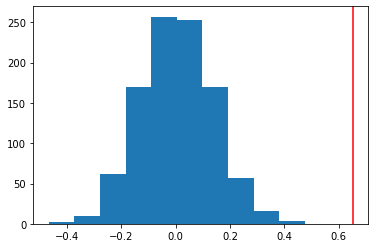

Here is the p-value: 0.0


In [2]:
# Subset the data into only two groups
iris_dat_sub = iris_dat[iris_dat['Species'].isin(['Iris-versicolor','Iris-virginica'])].reset_index()

# Permutation test - diff of means ----------------------

# Set the number of iterations
x = 1000

# Create an empty datasets
replicates = np.empty(x)

# Find the difference in means for the original data set
og_grouped = iris_dat_sub.loc[:,['SepalLengthCm','Species']].groupby('Species').mean()
og_mean_diff = og_grouped.iloc[1] - og_grouped.iloc[0]
print('Here are the original means for the Sepal Lengths of the two species \n')
print(og_grouped)

# Run a loop for the number of permutations we want to do
for i in range(x):
    permuted_dat_base = np.random.permutation(iris_dat_sub['SepalLengthCm']) # permute (shuffle) the data
    permuted_dat = pd.concat([pd.Series(permuted_dat_base),iris_dat_sub['Species']], axis=1) # re-assign data points to random species
    grouped_dat = permuted_dat.groupby('Species').mean() # Calculate the permuted means for each species
    diff_of_means = grouped_dat.iloc[1] - grouped_dat.iloc[0] # Find the permuted mean difference for comparison to the original mean difference
    replicates[i] = diff_of_means # Add to our empty dataset
    
# Plot the replicates and compare to the original mean
plt.hist(replicates)
plt.axvline(og_mean_diff['SepalLengthCm']
, color='red')
plt.show()

# Compute the p-value
p_val = np.sum(replicates >= og_mean_diff['SepalLengthCm'])/len(replicates)
print('Here is the p-value: {}'.format(p_val))

# --------------------------------------------------------

# Example 1  - Results Interpretation

The p-value shows that there are no data points that we as or more extreme than our data point. This means that the Virginica Iris sepal lengths were statistically signifantly longer than the Versicolor Iris sepal lengths. If our mean difference would have been negative, we would have calculated our p-value by seeing how many replicates were below the original mean difference. This is because the definition of a p-value is finding values as or more extreme than what was observed. In this case, this translates to the area of the distribution greater than the mean differences we observed. 

One thing to note is we could have had our test statistic be based on the medians instead of the mean as well. That's part of the flexibility of the permutation test, you can choose your test statistic. In the next example, I will use a permutation test on the cars dataset using correlation.

One more thing that would be good to do is plot the cumulative distribution function to check the distribution of your data. This can also help you get a sense if the difference is significant or not.

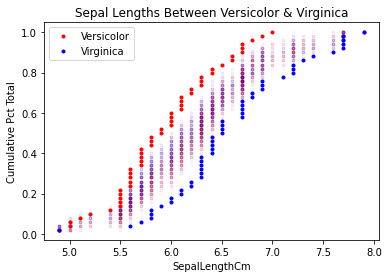

In [3]:
# Credit for this function: DataCamp course: 'Statistical Thinking in Python (Part 1)'
def ecdf(data): 
    """Compute ECDF for a one-dimensional array of measurements.""" 
    
    # Number of data points: n 
    n = len(data) 

    # x-data for the ECDF: x 
    x = np.sort(data) 

    # y-data for the ECDF: y 
    y = np.arange(1, n + 1) / n 

    return x, y 

# Credit for this idea: DataCamp course: 'Statistical Thinking in Python (Part 2)'
for _ in range(50):
    
    # Generate permutation samples
    permuted_dat_base = np.random.permutation(iris_dat_sub['SepalLengthCm']) # permute (shuffle) the data
    permuted_dat = pd.concat([pd.Series(permuted_dat_base),iris_dat_sub['Species']], axis=1) # re-assign data points to random species
    perm_versicolor = permuted_dat[permuted_dat['Species'] == 'Iris-versicolor'].iloc[:,0]
    perm_virginica  = permuted_dat[permuted_dat['Species'] == 'Iris-virginica'].iloc[:,0]
    
    # Compute ECDFs
    x_1, y_1 = ecdf(perm_versicolor)
    x_2, y_2 = ecdf(perm_virginica)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(iris_dat[iris_dat['Species'] == 'Iris-versicolor']['SepalLengthCm'])
x_2, y_2 = ecdf(iris_dat[iris_dat['Species'] == 'Iris-virginica']['SepalLengthCm'])
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', label='Versicolor')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue', label='Virginica')
plt.xlabel('SepalLengthCm')
plt.ylabel('Cumulative Pct Total')
plt.title('Sepal Lengths Between Versicolor & Virginica')
plt.legend()
plt.show()

You can see that the permutations are clearly inbetween the versicolor and virginica petal lengths, which also visually indicates that they are significantly different. The last thing to really drive this home is comparing this to the result from a two-sample t-test, which you could also do for this data assuming it is normally distributed.

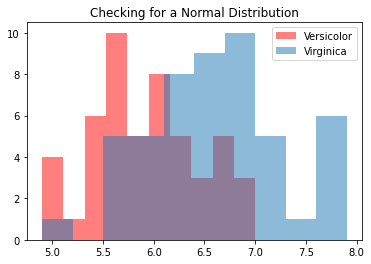

Here is the p-value for a two-sample test: 8.624281512273655e-08


In [4]:
versicolor = iris_dat[iris_dat['Species'] == 'Iris-versicolor']['SepalLengthCm']
virginica = iris_dat[iris_dat['Species'] == 'Iris-virginica']['SepalLengthCm']

plt.hist(versicolor, color='red', alpha=.5, label='Versicolor')
plt.title('Checking for a Normal Distribution')
plt.hist(virginica, alpha=.5, label='Virginica')
plt.legend()
plt.show()

print('Here is the p-value for a two-sample test: {}'.format(ttest_ind(virginica, versicolor, alternative='larger')[1])) # two-sample

You can see that the two-sample t-test also has a p-value very close to 0

# Example 2 - Cars Dataset

We will use the cars dataset from the UCI Machine Learning Repository to help demonstrate a permutation on a correlation between two variables. We want to know if the correlation between the mpg and weight of a car is significant. We will then use a linear regression to verify our results. The null hypothesis is the correlation is 0 and the alternate hypothesis is that there is a correlation.

In [5]:
car_dat.head(10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190,3850,8.5,70,1,amc ambassador dpl


Text(0.5, 1.0, 'MPG as a Function of Weight')

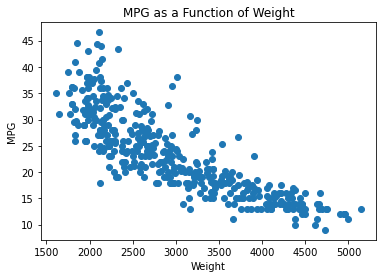

In [6]:
plt.scatter(car_dat['weight'], car_dat['mpg'])
plt.ylabel('MPG')
plt.xlabel('Weight')
plt.title('MPG as a Function of Weight')

You can see that there does seem to be a negative correlation between weight and mpg. Let's test this using a permutation test. 

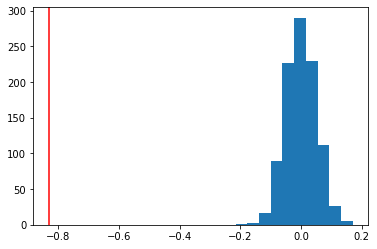

Here is the p-value: 0.0


In [7]:
# Set the number of iterations to run our permutations
x = 1000

# Our test statistic is correlation, so we will find our value to test our null hypothesis
og_coeff = np.corrcoef(car_dat['mpg'], car_dat['weight'])[0][1]

# Create empty dataframe to put correlation coefficients in
replicates = np.empty(x)

# Run a loop for the number of permutations we want to do
for i in range(x):
    permuted_dat_base = np.random.permutation(car_dat['mpg']) # permute (shuffle) the data
    permuted_dat = pd.concat([pd.Series(permuted_dat_base),car_dat['weight']], axis=1) # re-assign data points to random car weights
    replicates[i] = np.corrcoef(permuted_dat.iloc[:,0], permuted_dat['weight'])[0][1] # Add to our empty dataset
    
# Plot the replicates and compare to the original correlation
plt.hist(replicates)
plt.axvline(og_coeff
, color='red')
plt.show()

# Compute the p-value
p_val = np.sum(replicates <= og_coeff)/len(replicates)
print('Here is the p-value: {}'.format(p_val))

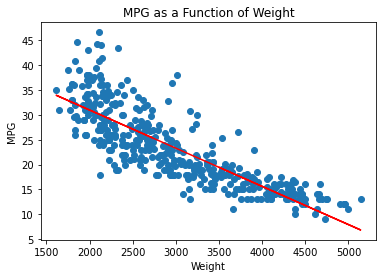

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     888.9
Date:                Thu, 18 Feb 2021   Prob (F-statistic):          2.97e-103
Time:                        14:57:09   Log-Likelihood:                -1148.4
No. Observations:                 398   AIC:                             2301.
Df Residuals:                     396   BIC:                             2309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.3174      0.795     58.243      0.000      44.754      47.881
weight        -0.0077      0.000    -29.814      0.000      -0.008      -0.007
==============================================================================
Omnibus:                       40.423   Durbin-Watson:                   0.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.695
Skew:                           0.713   Prob(JB):                     4.89e-13
Kurtosis:                       4.176   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
x = sm.ols('mpg ~ weight', data = car_dat).fit()
plt.scatter(car_dat['weight'], car_dat['mpg'])
plt.plot(car_dat['weight'],x.predict(), color='red')
# plt.xlabel('weight')
plt.ylabel('MPG')
plt.xlabel('Weight')
plt.title('MPG as a Function of Weight')
plt.show()
display(x.summary())


# Example 2  - Results Interpretation

The p values for both the permutation test was 0 and the linear regression test supports that finding. This is another example of how you can use a permutation test on a metric besides difference of means.

# Warning

The permutation test doesn't give the same p-value all the time due to the nature of the random shuffling. The histogram below shows a distribution of p-values that were given by a permutation test for data that was built from the same normal distribution. This variability in the p-value will decrease with the size of your data. So be careful with small datasets and  and p-values that are really close to your level of significance. If you wanted to be really strict with deciding whether something is significant or not, you could plot the distribution of the p-values and only use the mean p-value as your final p-value. Variation might also be reduced by using a t-statistic as your test statistic instead of a mean difference.

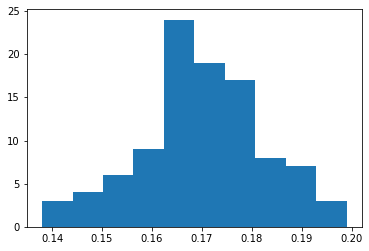

In [9]:
# Test Datasets
data_norm1 = np.random.normal(55,.2,1000)
data_norm2  = np.random.normal(55,.2,1000)

# Set the number of iterations
x = 1000

# Create an empty datasets
replicates = np.empty(x)
p_val = []

# Run a loop for the number of p_values we want
for z in range(100):
    
    # Find the difference in means for the original data set
    og_mean_diff = np.mean(data_norm1) - np.mean(data_norm2)
    
    # Run a loop for the number of permutations we want to do
    for i in range(x):

        # Generate permutation samples
        permuted_dat_base = np.random.permutation(data_norm1) # permute (shuffle) the data
        permuted_dat = pd.concat([pd.Series(permuted_dat_base),pd.Series(data_norm2)], axis=1) # re-assign data points to random species
        replicates[i] = np.mean(permuted_dat.iloc[:,0]) - np.mean(permuted_dat.iloc[:,1])
    
    # Need to 
    if og_mean_diff > 0:
        p = np.sum(og_mean_diff>=replicates)/len(replicates)
    else:
        p = np.sum(og_mean_diff<replicates)/len(replicates)
    
    # Append p-values to my list
    p_val.append(p)

plt.hist(p_val)
plt.show()

# Conclusion

In these examples, I used common datasets and compared the results to typical statistical tests. In both situations, the p-values matched the statistical tests you would normally use. In this notebook, I demonstrated the permutation method compared to a typical statistical test in order to increase your confidence to use this test on non-normally distributed datasets. The permutation test is a great tool due to its flexibility to be used on a variety of datasets. Its flexibility is due to that fact that it makes no assumptions about the underlying distribution of your data. I hope you found this useful and can use it in your work, please upvote if you liked the content. Also, any feedback is appreciated! Thanks!